In [11]:
# Apple Metal (MPS) setup for TensorFlow on macOS
import os, platform, sys, time
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())

# List devices
cpus = tf.config.list_physical_devices("CPU")
gpus = tf.config.list_physical_devices("GPU")
print("CPUs:", cpus)
print("GPUs:", gpus)

# If a GPU is visible on macOS, it's the Metal (MPS) backend.
USING_MPS = (len(gpus) > 0 and platform.system() == "Darwin")
print("Using MPS:", USING_MPS)

# Optional: enable mixed precision if MPS is available (can speed up training)
try:
    if USING_MPS:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy("mixed_float16")
        print("Mixed precision enabled (mixed_float16)")
except Exception as e:
    print("Mixed precision not enabled:", e)

# Quick sanity compute on the fastest device available
try:
    device = "/GPU:0" if USING_MPS else "/CPU:0"
    with tf.device(device):
        a = tf.random.normal([4096, 4096])
        b = tf.random.normal([4096, 4096])
        t0 = time.time()
        c = tf.matmul(a, b)
        _ = c.numpy()
        dt = time.time() - t0
    print(f"Sanity matmul ran on {device} in {dt:.3f}s")
except Exception as e:
    print("Sanity compute failed:", e)

TensorFlow: 2.20.0
Python: 3.13.5
Platform: macOS-26.0.1-arm64-arm-64bit-Mach-O
CPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs: []
Using MPS: False
Sanity matmul ran on /CPU:0 in 0.133s
Sanity matmul ran on /CPU:0 in 0.133s


In [12]:
"""
Handwritten Text Recognition Using Deep Learning: A CNN-LSTM Approach
"""

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# ============================================================================
# 1. PREPROCESSING FUNCTIONS
# ============================================================================

def grayscale_conversion(image):
    """Convert RGB image to grayscale using weighted sum"""
    if len(image.shape) == 3:
        # Formula: I_gray = 0.2989*R + 0.5870*G + 0.1140*B
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    return gray


def binarization(gray_image, method='otsu'):
    """Apply thresholding to convert grayscale to binary"""
    if method == 'otsu':
        _, binary = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'huang':
        threshold = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)[0]
        _, binary = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)
    else:
        _, binary = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    return binary


def resize_and_pad(image, target_height=32, target_width=128):
    """Resize image to fixed dimensions with padding"""
    h, w = image.shape[:2]
    
    # Calculate scaling factor to maintain aspect ratio
    scale = min(target_height / h, target_width / w)
    new_h, new_w = int(h * scale), int(w * scale)
    
    # Resize image
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create padded image with white background
    padded = np.ones((target_height, target_width), dtype=np.uint8) * 255
    
    # Calculate padding offsets
    y_offset = (target_height - new_h) // 2
    x_offset = (target_width - new_w) // 2
    
    # Place resized image in center
    padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    return padded


def image_inversion(binary_image):
    """Invert pixel intensities (black text on white becomes white text on black)"""
    inverted = 255 - binary_image
    return inverted


def normalize_image(image):
    """Normalize pixel values to range [0, 1]"""
    normalized = image.astype(np.float32) / 255.0
    return normalized


def preprocess_image(image_path, target_height=32, target_width=128):
    """Complete preprocessing pipeline"""
    # Read image
    image = cv2.imread(str(image_path))
    
    # Step 1: Grayscale conversion
    gray = grayscale_conversion(image)
    
    # Step 2: Binarization
    binary = binarization(gray, method='otsu')
    
    # Step 3: Resize and pad
    resized = resize_and_pad(binary, target_height, target_width)
    
    # Step 4: Image inversion (optional, depending on dataset)
    # inverted = image_inversion(resized)
    
    # Step 5: Normalization
    normalized = normalize_image(resized)
    
    # Add channel dimension
    preprocessed = np.expand_dims(normalized, axis=-1)
    
    return preprocessed


# ============================================================================
# 2. CHARACTER ENCODING
# ============================================================================

class CharacterEncoder:
    """Encode and decode characters for model training"""
    
    def __init__(self, characters=None):
        if characters is None:
            # Default character set (lowercase + uppercase + digits + space)
            self.characters = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,!?'-"
        else:
            self.characters = characters
        
        # Create character to index mapping (start from 0)
        # CTC blank token will be at index len(characters) automatically
        self.char_to_num = {char: idx for idx, char in enumerate(self.characters)}
        
        # Create index to character mapping
        self.num_to_char = {idx: char for char, idx in self.char_to_num.items()}
        
        # Vocab size includes all characters + blank token at the end
        self.vocab_size = len(self.characters) + 1  # +1 for CTC blank
        self.blank_token_idx = len(self.characters)  # Blank is last index
    
    def encode(self, text):
        """Encode text to numerical indices (0 to len(characters)-1)"""
        encoded = []
        for char in text:
            if char in self.char_to_num:
                encoded.append(self.char_to_num[char])
            # Skip unknown characters instead of using blank
        return encoded
    
    def decode(self, indices):
        """Decode numerical indices to text (skip blank token)"""
        decoded = []
        for idx in indices:
            if idx < len(self.characters) and idx in self.num_to_char:
                decoded.append(self.num_to_char[idx])
            # Skip blank token (self.blank_token_idx) and unknown indices
        return ''.join(decoded)


# ============================================================================
# 3. CNN-LSTM MODEL ARCHITECTURE
# ============================================================================

def build_crnn_model(input_shape=(32, 128, 1), num_classes=79):
    """
    Build CRNN model with 6 Conv layers and 2 BiLSTM layers
    Architecture from the paper
    """
    
    # Input layer
    input_layer = layers.Input(shape=input_shape, name='input_1')
    
    # Convolutional Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d')(input_layer)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d')(x)
    
    # Convolutional Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_1')(x)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_1')(x)
    
    # Convolutional Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv2d_2')(x)
    
    # Convolutional Block 4
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv2d_3')(x)
    x = layers.MaxPooling2D((2, 1), name='max_pooling2d_2')(x)
    
    # Convolutional Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2d_4')(x)
    x = layers.BatchNormalization(name='batch_normalization')(x)
    
    # Convolutional Block 6
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2d_5')(x)
    x = layers.BatchNormalization(name='batch_normalization_1')(x)
    x = layers.MaxPooling2D((2, 1), name='max_pooling2d_3')(x)
    
    # Convolutional Block 7
    x = layers.Conv2D(512, (2, 2), activation='relu', name='conv2d_6')(x)
    
    # Reshape for LSTM (Lambda layer)
    # Shape: (batch, height, width, channels) -> (batch, width, height*channels)
    x = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name='lambda')(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2), 
                            name='bidirectional')(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2), 
                            name='bidirectional_1')(x)
    
    # Dense output layer
    output = layers.Dense(num_classes, activation='softmax', name='dense')(x)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output, name='CRNN_HTR')
    
    return model


# ============================================================================
# 4. CTC LOSS FUNCTION
# ============================================================================

def ctc_loss_function(y_true, y_pred):
    """CTC (Connectionist Temporal Classification) loss"""
    # Get batch size
    batch_size = tf.shape(y_true)[0]
    
    # Input length (time steps from model output)
    input_length = tf.shape(y_pred)[1] * tf.ones(shape=(batch_size, 1), dtype='int32')
    
    # Label length (actual label sequence length)
    label_length = tf.reduce_sum(tf.cast(y_true != 0, tf.int32), axis=-1, keepdims=True)
    
    # Calculate CTC loss
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    
    return loss


# ============================================================================
# 5. DATA GENERATOR
# ============================================================================

class HTRDataGenerator(keras.utils.Sequence):
    """Data generator for HTR training"""
    
    def __init__(self, image_paths, labels, encoder, batch_size=5, 
                 img_height=32, img_width=128, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.encoder = encoder
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        """Number of batches per epoch"""
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Generate data
        X, y = self.__data_generation(indexes)
        
        return X, y
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, indexes):
        """Generate data for a batch"""
        # Initialize arrays
        X = np.zeros((self.batch_size, self.img_height, self.img_width, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, 64), dtype=np.int32)  # Max label length = 64
        
        # Generate data
        for i, idx in enumerate(indexes):
            # Load and preprocess image
            img = preprocess_image(self.image_paths[idx], self.img_height, self.img_width)
            X[i] = img
            
            # Encode label
            encoded_label = self.encoder.encode(self.labels[idx])
            y[i, :len(encoded_label)] = encoded_label
        
        return X, y


# ============================================================================
# 6. JARO-WINKLER SIMILARITY
# ============================================================================

def jaro_winkler_similarity(str1, str2):
    """Calculate Jaro-Winkler similarity between two strings"""
    
    def jaro_similarity(s1, s2):
        if len(s1) == 0 and len(s2) == 0:
            return 1.0
        if len(s1) == 0 or len(s2) == 0:
            return 0.0
        
        match_distance = max(len(s1), len(s2)) // 2 - 1
        s1_matches = [False] * len(s1)
        s2_matches = [False] * len(s2)
        
        matches = 0
        transpositions = 0
        
        for i in range(len(s1)):
            start = max(0, i - match_distance)
            end = min(i + match_distance + 1, len(s2))
            
            for j in range(start, end):
                if s2_matches[j] or s1[i] != s2[j]:
                    continue
                s1_matches[i] = True
                s2_matches[j] = True
                matches += 1
                break
        
        if matches == 0:
            return 0.0
        
        k = 0
        for i in range(len(s1)):
            if not s1_matches[i]:
                continue
            while not s2_matches[k]:
                k += 1
            if s1[i] != s2[k]:
                transpositions += 1
            k += 1
        
        return (matches / len(s1) + matches / len(s2) + 
                (matches - transpositions / 2) / matches) / 3
    
    jaro_sim = jaro_similarity(str1, str2)
    
    # Calculate prefix length (max 4)
    prefix = 0
    for i in range(min(len(str1), len(str2), 4)):
        if str1[i] == str2[i]:
            prefix += 1
        else:
            break
    
    # Calculate Jaro-Winkler similarity
    jaro_winkler = jaro_sim + (prefix * 0.1 * (1 - jaro_sim))
    
    return jaro_winkler


# ============================================================================
# 7. TRAINING FUNCTION
# ============================================================================

def train_model(model, train_generator, val_generator, epochs=25, 
                checkpoint_path='best_model.h5'):
    """Train the CRNN model"""
    
    # Compile model with SGD optimizer
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss=ctc_loss_function)
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )
    
    return history


# ============================================================================
# 8. PREDICTION AND DECODING
# ============================================================================

def decode_predictions(predictions, encoder, blank_index=None):
    """Decode CTC predictions to text
    
    Args:
        predictions: numpy array of shape (batch_size, time_steps, num_classes)
        encoder: CharacterEncoder instance
        blank_index: Index of blank token (optional, uses encoder.blank_token_idx)
    
    Returns:
        List of decoded text strings
    """
    if blank_index is None:
        blank_index = encoder.blank_token_idx
    
    decoded_texts = []
    
    # predictions shape: (batch_size, time_steps, num_classes)
    batch_size = predictions.shape[0]
    time_steps = predictions.shape[1]
    
    # Create input_length for all samples in batch
    input_lengths = np.full((batch_size,), time_steps, dtype=np.int32)
    
    # Decode all predictions at once
    decoded, _ = tf.keras.backend.ctc_decode(
        predictions,
        input_length=input_lengths,
        greedy=True
    )
    
    # Convert to text
    decoded = decoded[0].numpy()
    for i in range(batch_size):
        # Get the decoded sequence for this sample
        seq = decoded[i]
        # Decode to text using encoder
        text = encoder.decode(seq)
        decoded_texts.append(text)
    
    return decoded_texts


# ============================================================================
# 9. VISUALIZATION FUNCTIONS
# ============================================================================

def plot_training_history(history, epochs_trained):
    """Plot training and validation accuracy/loss"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Training and Validation Loss ({epochs_trained} Epochs)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy (if available)
    if 'accuracy' in history.history:
        ax2.plot(history.history['accuracy'], label='Training Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title(f'Training and Validation Accuracy ({epochs_trained} Epochs)')
        ax2.legend()
        ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'training_history_{epochs_trained}_epochs.png')
    plt.show()


def visualize_predictions(image_paths, true_labels, predicted_labels, num_samples=5):
    """Visualize predictions with original images"""
    
    num_samples = min(num_samples, len(image_paths))
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, num_samples * 2))
    
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        # Load and display image
        img = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        
        # Calculate similarity
        similarity = jaro_winkler_similarity(true_labels[i], predicted_labels[i])
        
        # Set title with true and predicted text
        title = f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]}\nSimilarity: {similarity:.2%}"
        axes[i].set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()


# ============================================================================
# 10. MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""
    
    print("=" * 80)
    print("Handwritten Text Recognition Using CNN-LSTM")
    print("=" * 80)
    
    # Initialize character encoder
    print("\n[1/7] Initializing character encoder...")
    encoder = CharacterEncoder()
    print(f"Vocabulary size: {encoder.vocab_size}")
    
    # Build model
    print("\n[2/7] Building CRNN model...")
    model = build_crnn_model(input_shape=(32, 128, 1), num_classes=encoder.vocab_size)
    model.summary()
    
    # Print model statistics
    total_params = model.count_params()
    print(f"\nTotal parameters: {total_params:,}")
    
    print("\n[3/7] Model architecture successfully created!")
    print("\nNote: To train the model, you need:")
    print("  - IAM Dataset with image paths and labels")
    print("  - Create train/validation data generators")
    print("  - Call train_model() function")
    
    print("\n[4/7] Example usage:")
    print("""
    # Example: Load your dataset
    train_images = ['path/to/image1.png', 'path/to/image2.png', ...]
    train_labels = ['hello', 'world', ...]
    
    # Create data generator
    train_gen = HTRDataGenerator(train_images, train_labels, encoder, batch_size=5)
    val_gen = HTRDataGenerator(val_images, val_labels, encoder, batch_size=5)
    
    # Train model
    history = train_model(model, train_gen, val_gen, epochs=50)
    
    # Evaluate
    predictions = model.predict(test_images)
    decoded = decode_predictions(predictions, encoder)
    """)
    
    print("\n[5/7] Preprocessing example:")
    # Create a sample image for demonstration
    sample_img = np.ones((50, 200, 3), dtype=np.uint8) * 255
    cv2.putText(sample_img, "SAMPLE", (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    cv2.imwrite('sample_input.png', sample_img)
    
    # Preprocess it
    preprocessed = preprocess_image('sample_input.png')
    print(f"Preprocessed shape: {preprocessed.shape}")
    print(f"Value range: [{preprocessed.min():.2f}, {preprocessed.max():.2f}]")
    
    print("\n[6/7] Character encoding example:")
    sample_text = "Hello World"
    encoded = encoder.encode(sample_text)
    decoded = encoder.decode(encoded)
    print(f"Original: {sample_text}")
    print(f"Encoded: {encoded}")
    print(f"Decoded: {decoded}")
    
    print("\n[7/7] Jaro-Winkler similarity example:")
    text1 = "recognition"
    text2 = "recogniton"
    similarity = jaro_winkler_similarity(text1, text2)
    print(f"'{text1}' vs '{text2}': {similarity:.2%}")
    
    print("\n" + "=" * 80)
    print("Setup complete! Model ready for training.")
    print("=" * 80)
    
    return model, encoder


if __name__ == "__main__":
    model, encoder = main()


Handwritten Text Recognition Using CNN-LSTM

[1/7] Initializing character encoder...
Vocabulary size: 70

[2/7] Building CRNN model...


Model: "CRNN_HTR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 128, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 32, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 32, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 32, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 32, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 31, 512)     │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 31, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31, 70)         │        35,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,738,630 (33.34 MB)

 Trainable params: 8,736,582 (33.33 MB)

 Non-trainable params: 2,048 (8.00 KB)


Total parameters: 8,738,630

[3/7] Model architecture successfully created!

Note: To train the model, you need:
  - IAM Dataset with image paths and labels
  - Create train/validation data generators
  - Call train_model() function

[4/7] Example usage:

    # Example: Load your dataset
    train_images = ['path/to/image1.png', 'path/to/image2.png', ...]
    train_labels = ['hello', 'world', ...]

    # Create data generator
    train_gen = HTRDataGenerator(train_images, train_labels, encoder, batch_size=5)
    val_gen = HTRDataGenerator(val_images, val_labels, encoder, batch_size=5)

    # Train model
    history = train_model(model, train_gen, val_gen, epochs=50)

    # Evaluate
    predictions = model.predict(test_images)
    decoded = decode_predictions(predictions, encoder)
    

[5/7] Preprocessing example:
Preprocessed shape: (32, 128, 1)
Value range: [0.00, 1.00]

[6/7] Character encoding example:
Original: Hello World
Encoded: [34, 5, 12, 12, 15, 0, 49, 15, 18, 12, 4]
Decode

HANDWRITTEN TEXT RECOGNITION - IAM DATASET TRAINING

STEP 1: LOADING DATASET
Loading training/validation from: /Users/raghav_sarna/Desktop/Drive/Plaksha/Semester 5/DL/handwriting/handwriting_autocomplete_system/hdf5_train_ocr/data/iam/trnvalset_words64_OrgSz.hdf5
Loading test set from: /Users/raghav_sarna/Desktop/Drive/Plaksha/Semester 5/DL/handwriting/handwriting_autocomplete_system/hdf5_train_ocr/data/iam/testset_words64_OrgSz.hdf5
Loading test set from: /Users/raghav_sarna/Desktop/Drive/Plaksha/Semester 5/DL/handwriting/handwriting_autocomplete_system/hdf5_train_ocr/data/iam/testset_words64_OrgSz.hdf5

DATASET STATISTICS (HDF5)
Train/Val pool samples: 52,231
Test samples: 11,170
Unique characters: 69

STEP 2: PREPARING DATA

Splitting data: Train/Val/Test
✓ Train: 37736 samples (72.2%)
✓ Validation: 6660 samples (12.8%)
✓ Test: 7835 samples (15.0%)

✓ Character set created: 70 unique characters
Characters:  "'+,-./0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz...

✓ 

Model: "CRNN_HTR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 128, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 32, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 32, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 32, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 32, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 31, 512)     │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 31, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31, 71)         │        36,423 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,739,143 (33.34 MB)

 Trainable params: 8,737,095 (33.33 MB)

 Non-trainable params: 2,048 (8.00 KB)


STEP 5: TRAINING MODEL
Epochs: 25
Batch size: 32
Model will be saved to: htr_model_20251106_201701.weights.h5

Epoch 1/25
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 15.4888
Epoch 1: val_loss improved from None to 10.60020, saving model to htr_model_20251106_201701.weights.weights.h5

Epoch 1: val_loss improved from None to 10.60020, saving model to htr_model_20251106_201701.weights.weights.h5
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 357s 300ms/step - loss: 13.1498 - val_loss: 10.6002 - learning_rate: 0.0010
Epoch 2/25
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 357s 300ms/step - loss: 13.1498 - val_loss: 10.6002 - learning_rate: 0.0010
Epoch 2/25
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 8.9785
Epoch 2: val_loss improved from 10.60020 to 5.01291, saving model to htr_model_20251106_201701.weights.weights.h5

Epoch 2: val_loss improved from 10.60020 to 5.01291, saving model to htr_model_20251106_201701.weights.weights.h5
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 350s 297ms/step - loss: 7.5698 - val_


✓ Training history saved to: history_20251106_201701.pkl
✓ Base model saved to: htr_model_20251106_201701_base.h5

STEP 6: PLOTTING TRAINING HISTORY


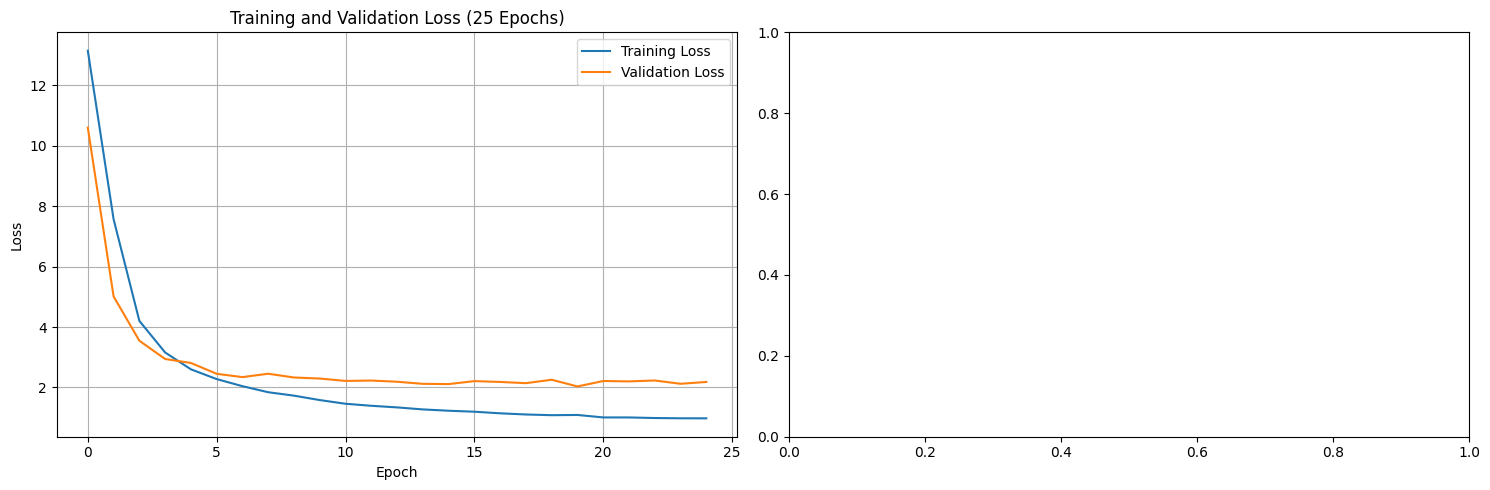


STEP 7: EVALUATING MODEL

EVALUATING MODEL
Preprocessing 100 samples...
  Processed 100/100...

Making predictions...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Decoding predictions...

Calculating metrics...

EVALUATION RESULTS
Samples evaluated: 100
Exact match accuracy: 55.00%
Average similarity: 88.40%
Median similarity: 100.00%
Character Error Rate (CER): 17.73%
Word Error Rate (WER): 45.00%
✓ Predictions saved to: predictions_20251106_201701.txt

STEP 8: VISUALIZING PREDICTIONS


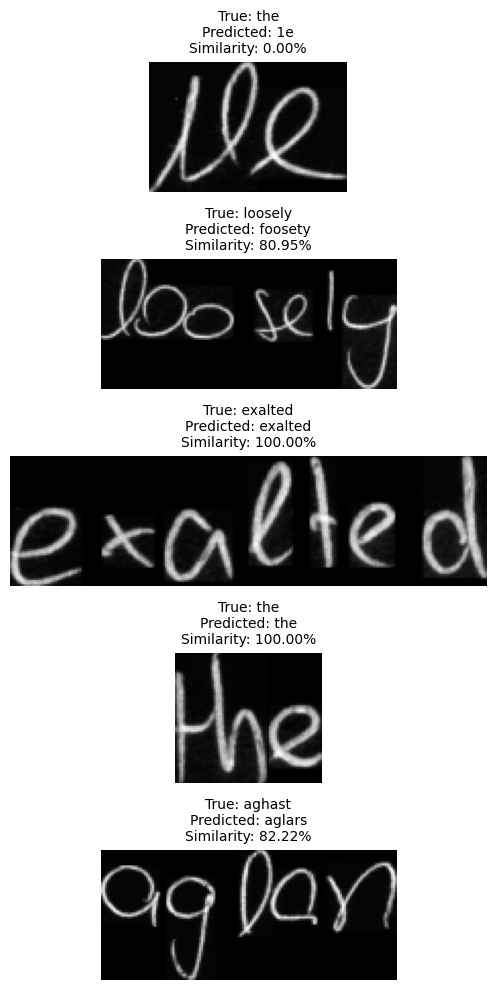


TRAINING COMPLETE!
✓ Model saved: htr_model_20251106_201701.weights.h5
✓ Encoder saved: encoder_20251106_201701.pkl
✓ History saved: history_20251106_201701.pkl
✓ Predictions saved: predictions_20251106_201701.txt

Final Performance:
  - Character Error Rate (CER): 17.73%
  - Word Error Rate (WER): 45.00%
  - Average Similarity: 88.40%



In [13]:
"""
Training Script for Handwritten Text Recognition using IAM Dataset (HDF5 or Kaggle files)
This script can load the local HDF5 IAM dataset under data/iam or the Kaggle-style folder.
"""

import os
import sys
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from pathlib import Path
import pickle
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
import h5py

# NOTE: The model, preprocessing, and visualization helpers are defined in Cell 1
# We will reuse: CharacterEncoder, build_crnn_model, decode_predictions,
# plot_training_history, visualize_predictions, jaro_winkler_similarity, preprocess_image

# ============================================================================
# 1. IAM DATASET CONFIGURATION (Kaggle-style folders) - kept for optional use
# ============================================================================

class IAMDatasetConfig:
    """Configuration for IAM Dataset paths (Kaggle folder layout)"""
    
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.words_dir = self.base_path / 'iam_words' / 'words'
        self.lines_dir = self.base_path / 'iam_words' / 'lines'  # May not exist
        self.words_txt = self.words_dir / 'words.txt'
        if not self.words_txt.exists():
            self.words_txt = self.base_path / 'words_new.txt'
        if not self.words_txt.exists():
            self.words_txt = self.base_path / 'iam_words' / 'words_new.txt'
        self.lines_txt = self.words_dir / 'lines.txt'
        if not self.lines_txt.exists():
            self.lines_txt = self.base_path / 'lines_new.txt'
    
    def validate(self):
        print(f"\nValidating dataset at: {self.base_path}")
        if not self.base_path.exists():
            raise FileNotFoundError(f"Base path does not exist: {self.base_path}")
        if not self.words_dir.exists():
            raise FileNotFoundError(f"Words directory not found: {self.words_dir}")
        if not self.words_txt.exists():
            raise FileNotFoundError(
                f"Annotation file not found. Checked:\n"
                f"  - {self.base_path / 'words.txt'}\n"
                f"  - {self.base_path / 'words_new.txt'}\n"
                f"  - {self.base_path / 'ascii' / 'words.txt'}\n"
                f"Please ensure words.txt exists in the dataset root."
            )
        print(f"✓ Base path: {self.base_path}")
        print(f"✓ Words directory: {self.words_dir}")
        print(f"✓ Annotation file: {self.words_txt}")
        print("✓ IAM Dataset paths validated successfully")
        return True


# ============================================================================
# 2. IAM DATASET LOADER (Kaggle) - kept for optional use
# ============================================================================

class IAMDatasetLoader:
    """Load and parse IAM Handwriting Dataset (Kaggle files)"""
    
    def __init__(self, config):
        self.config = config
        self.data = []
    
    def parse_words_file(self, max_samples=None):
        print(f"\nLoading IAM words from: {self.config.words_txt}")
        if not self.config.words_txt.exists():
            raise FileNotFoundError(f"Words file not found: {self.config.words_txt}")
        data = []
        skipped = 0
        with open(self.config.words_txt, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#') or len(line.strip()) == 0:
                    continue
                try:
                    parts = line.strip().split()
                    if len(parts) < 9:
                        skipped += 1
                        continue
                    word_id = parts[0]
                    status = parts[1]
                    transcription = ' '.join(parts[8:])
                    if status != 'ok' or len(transcription.strip()) == 0:
                        skipped += 1
                        continue
                    parts_id = word_id.split('-')
                    folder1 = parts_id[0]
                    folder2 = '-'.join(parts_id[:2])
                    image_path = self.config.words_dir / folder1 / folder2 / f"{word_id}.png"
                    if not image_path.exists():
                        skipped += 1
                        continue
                    data.append({
                        'word_id': word_id,
                        'image_path': str(image_path),
                        'transcription': transcription,
                        'status': status
                    })
                    if max_samples and len(data) >= max_samples:
                        break
                except Exception:
                    skipped += 1
                    continue
        print(f"✓ Loaded {len(data)} samples, skipped {skipped} samples")
        self.data = data
        return data
    
    def parse_lines_file(self, max_samples=None):
        print(f"\nLoading IAM lines from: {self.config.lines_txt}")
        if not self.config.lines_txt.exists():
            raise FileNotFoundError(f"Lines file not found: {self.config.lines_txt}")
        data = []
        skipped = 0
        with open(self.config.lines_txt, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('#') or len(line.strip()) == 0:
                    continue
                try:
                    parts = line.strip().split()
                    if len(parts) < 9:
                        skipped += 1
                        continue
                    line_id = parts[0]
                    status = parts[1]
                    transcription = ' '.join(parts[8:])
                    if status != 'ok' or len(transcription.strip()) == 0:
                        skipped += 1
                        continue
                    parts_id = line_id.split('-')
                    folder1 = parts_id[0]
                    folder2 = f"{parts_id[0]}-{parts_id[1]}"
                    image_path = self.config.lines_dir / folder1 / folder2 / f"{line_id}.png"
                    if not image_path.exists():
                        skipped += 1
                        continue
                    data.append({
                        'line_id': line_id,
                        'image_path': str(image_path),
                        'transcription': transcription,
                        'status': status
                    })
                    if max_samples and len(data) >= max_samples:
                        break
                except Exception:
                    skipped += 1
                    continue
        print(f"✓ Loaded {len(data)} samples, skipped {skipped} samples")
        self.data = data
        return data
    
    def get_statistics(self):
        if not self.data:
            print("No data loaded yet!")
            return
        transcriptions = [item['transcription'] for item in self.data]
        lengths = [len(t) for t in transcriptions]
        all_chars = set(''.join(transcriptions))
        stats = {
            'total_samples': len(self.data),
            'min_length': min(lengths),
            'max_length': max(lengths),
            'avg_length': np.mean(lengths),
            'unique_chars': len(all_chars),
            'characters': sorted(all_chars)
        }
        print("\n" + "="*80)
        print("DATASET STATISTICS")
        print("="*80)
        print(f"Total samples: {stats['total_samples']:,}")
        print(f"Text length - Min: {stats['min_length']}, Max: {stats['max_length']}, Avg: {stats['avg_length']:.2f}")
        print(f"Unique characters: {stats['unique_chars']}")
        print(f"Character set: {''.join(stats['characters'][:50])}...")
        print("="*80)
        return stats


# ============================================================================
# 3. DATA PREPARATION (common)
# ============================================================================

def prepare_data_for_training(data, test_size=0.15, val_size=0.15, random_state=42):
    print(f"\nSplitting data: Train/Val/Test")
    train_val_data, test_data = train_test_split(
        data, test_size=test_size, random_state=random_state
    )
    train_data, val_data = train_test_split(
        train_val_data, test_size=val_size, random_state=random_state
    )
    print(f"✓ Train: {len(train_data)} samples ({len(train_data)/len(data)*100:.1f}%)")
    print(f"✓ Validation: {len(val_data)} samples ({len(val_data)/len(data)*100:.1f}%)")
    print(f"✓ Test: {len(test_data)} samples ({len(test_data)/len(data)*100:.1f}%)")
    return train_data, val_data, test_data


def create_character_set(data):
    all_text = ' '.join([item['transcription'] for item in data])
    unique_chars = sorted(set(all_text))
    char_string = ''.join(unique_chars)
    print(f"\n✓ Character set created: {len(unique_chars)} unique characters")
    print(f"Characters: {char_string[:100]}...")
    return char_string


# ============================================================================
# 4. CTC-COMPATIBLE GENERATORS (paths and arrays)
# ============================================================================

class CTCDataGenerator(keras.utils.Sequence):
    """CTC-compatible data generator for images referenced by file paths"""
    
    def __init__(self, image_paths, labels, encoder, batch_size=32, 
                 img_height=32, img_width=128, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.encoder = encoder
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X_dict, y = self.__data_generation(indexes)
        return X_dict, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, indexes):
        valid_samples = []
        for idx in indexes:
            try:
                img = preprocess_image(self.image_paths[idx], self.img_height, self.img_width)
                encoded_label = self.encoder.encode(self.labels[idx])
                label_len = len(encoded_label)
                if label_len == 0:
                    continue
                valid_samples.append((img, encoded_label, label_len))
            except Exception as e:
                print(f"\nWarning: Skipping image {self.image_paths[idx]}: {e}")
                continue
        if len(valid_samples) == 0:
            valid_samples = [(np.zeros((self.img_height, self.img_width, 1), dtype=np.float32), [0], 1)]
        actual_batch_size = min(len(valid_samples), self.batch_size)
        X = np.zeros((actual_batch_size, self.img_height, self.img_width, 1), dtype=np.float32)
        y_labels = np.ones((actual_batch_size, 64), dtype=np.int32) * -1
        input_length = np.ones((actual_batch_size, 1), dtype=np.int32) * 31
        label_length = np.zeros((actual_batch_size, 1), dtype=np.int32)
        for i in range(actual_batch_size):
            img, encoded_label, label_len = valid_samples[i]
            X[i] = img
            y_labels[i, :label_len] = encoded_label
            label_length[i] = label_len
        return {
            'input_data': X,
            'y_true': y_labels,
            'input_length': input_length,
            'label_length': label_length
        }, np.zeros([actual_batch_size])


def preprocess_image_array(img_array, target_height=32, target_width=128):
    """Preprocess a grayscale image array to model input shape."""
    # Ensure 2D grayscale
    if img_array.ndim == 3:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    gray = img_array
    binary = binarization(gray, method='otsu')
    resized = resize_and_pad(binary, target_height, target_width)
    normalized = normalize_image(resized)
    return np.expand_dims(normalized, axis=-1)


class CTCArrayDataGenerator(keras.utils.Sequence):
    """CTC-compatible data generator for images provided as numpy arrays"""
    
    def __init__(self, images, labels, encoder, batch_size=32, 
                 img_height=32, img_width=128, shuffle=True):
        self.images = images
        self.labels = labels
        self.encoder = encoder
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.images))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X_dict, y = self.__data_generation(indexes)
        return X_dict, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, indexes):
        valid_samples = []
        for idx in indexes:
            try:
                img = preprocess_image_array(self.images[idx], self.img_height, self.img_width)
                encoded_label = self.encoder.encode(self.labels[idx])
                label_len = len(encoded_label)
                if label_len == 0:
                    continue
                valid_samples.append((img, encoded_label, label_len))
            except Exception as e:
                print(f"\nWarning: Skipping array image idx={idx}: {e}")
                continue
        if len(valid_samples) == 0:
            valid_samples = [(np.zeros((self.img_height, self.img_width, 1), dtype=np.float32), [0], 1)]
        actual_batch_size = min(len(valid_samples), self.batch_size)
        X = np.zeros((actual_batch_size, self.img_height, self.img_width, 1), dtype=np.float32)
        y_labels = np.ones((actual_batch_size, 64), dtype=np.int32) * -1
        input_length = np.ones((actual_batch_size, 1), dtype=np.int32) * 31
        label_length = np.zeros((actual_batch_size, 1), dtype=np.int32)
        for i in range(actual_batch_size):
            img, encoded_label, label_len = valid_samples[i]
            X[i] = img
            y_labels[i, :label_len] = encoded_label
            label_length[i] = label_len
        return {
            'input_data': X,
            'y_true': y_labels,
            'input_length': input_length,
            'label_length': label_length
        }, np.zeros([actual_batch_size])


# ============================================================================
# 5. CTC MODEL WRAPPER
# ============================================================================

def build_ctc_model(input_shape=(32, 128, 1), num_classes=78):
    """Build CTC model with proper loss handling"""
    from tensorflow.keras import layers, Model
    import tensorflow as tf
    
    input_data = layers.Input(name='input_data', shape=input_shape)
    y_true = layers.Input(name='y_true', shape=[64], dtype='int32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int32')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int32')
    base_model = build_crnn_model(input_shape, num_classes)
    y_pred = base_model(input_data)
    ctc_loss = layers.Lambda(
        lambda args: tf.keras.backend.ctc_batch_cost(args[0], args[1], args[2], args[3]),
        output_shape=(1,),
        name='ctc'
    )([y_true, y_pred, input_length, label_length])
    model = Model(inputs=[input_data, y_true, input_length, label_length], outputs=ctc_loss)
    model.base_model = base_model
    return model


# ============================================================================
# 6. TRAINING FUNCTION
# ============================================================================

def train_ctc_model(model, train_generator, val_generator, epochs=25, checkpoint_path='best_model.h5'):
    """Train the CTC model"""
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
    model.compile(optimizer=Adam(learning_rate=0.001), loss={'ctc': lambda y_true, y_pred: y_pred})
    weights_path = checkpoint_path.replace('.h5', '.weights.h5') if checkpoint_path.endswith('.h5') else checkpoint_path + '.weights.h5'
    checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1, save_weights_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[checkpoint, early_stopping, reduce_lr], verbose=1)
    return history


# ============================================================================
# 7. HDF5 DATASET LOADER (local data/iam/*.hdf5)
# ============================================================================

def load_hdf5_samples(h5_path, max_samples=None):
    """Load samples from an HDF5 file with IAM format used in this repo.
    Expected keys: imgs, lbs, img_seek_idxs, lb_seek_idxs, img_lens, lb_lens.
    Returns a list of dicts with 'image' (H x W uint8) and 'transcription' (str).
    """
    h5_path = Path(h5_path)
    if not h5_path.exists():
        raise FileNotFoundError(f"HDF5 file not found: {h5_path}")
    samples = []
    with h5py.File(h5_path, 'r') as f:
        keys = set(f.keys())
        # Case 1: concatenated storage
        if {'imgs','lbs','img_seek_idxs','lb_seek_idxs','img_lens','lb_lens'}.issubset(keys):
            imgs = f['imgs'][:]
            lbs = f['lbs'][:]
            img_seek = f['img_seek_idxs'][:]
            img_lens = f['img_lens'][:]
            lb_seek = f['lb_seek_idxs'][:]
            lb_lens = f['lb_lens'][:]
            n = len(img_lens)
            for i in range(n):
                x0 = img_seek[i]
                w = int(img_lens[i])
                img = imgs[:, x0:x0+w]
                y0 = lb_seek[i]
                l = int(lb_lens[i])
                text = ''.join(chr(int(c)) for c in lbs[y0:y0+l])
                samples.append({'image': img, 'transcription': text})
                if max_samples and len(samples) >= max_samples:
                    break
        # Case 2: naive arrays per-sample
        elif 'images' in keys and 'labels' in keys:
            images = f['images'][:]
            labels = f['labels'][:]
            for i in range(len(images)):
                img = images[i]
                lab = labels[i]
                if isinstance(lab, bytes):
                    text = lab.decode('utf-8')
                else:
                    text = str(lab)
                samples.append({'image': img, 'transcription': text})
                if max_samples and len(samples) >= max_samples:
                    break
        else:
            raise ValueError(f"Unrecognized HDF5 structure in {h5_path}. Keys: {sorted(keys)}")
    return samples


# ============================================================================
# 8. EVALUATION FUNCTIONS (support paths or arrays)
# ============================================================================

def evaluate_model(model, test_data, encoder, batch_size=32, max_samples=100):
    """Evaluate model on test set. Supports test_data items with 'image_path' or 'image'."""
    print("\n" + "="*80)
    print("EVALUATING MODEL")
    print("="*80)
    if max_samples:
        test_data = test_data[:max_samples]
    image_paths = []
    images = []
    true_labels = [item['transcription'] for item in test_data]
    print(f"Preprocessing {len(true_labels)} samples...")
    for i, item in enumerate(test_data):
        if (i + 1) % 100 == 0:
            print(f"  Processed {i+1}/{len(true_labels)}...")
        if 'image_path' in item:
            image_paths.append(item['image_path'])
            img = preprocess_image(item['image_path'])
        else:
            image_paths.append(None)
            img = preprocess_image_array(item['image'])
        images.append(img)
    images = np.array(images)
    print("\nMaking predictions...")
    prediction_model = model.base_model if hasattr(model, 'base_model') else model
    predictions = prediction_model.predict(images, batch_size=batch_size, verbose=1)
    print("Decoding predictions...")
    predicted_labels = decode_predictions(predictions, encoder)
    print("\nCalculating metrics...")
    similarities = []
    correct_predictions = 0
    cer_scores = []
    wer_scores = []
    for true, pred in zip(true_labels, predicted_labels):
        sim = jaro_winkler_similarity(true, pred)
        similarities.append(sim)
        if true.strip() == pred.strip():
            correct_predictions += 1
        cer_scores.append(calculate_cer(true, pred))
        wer_scores.append(calculate_wer(true, pred))
    results = {
        'num_samples': len(test_data),
        'exact_match_accuracy': correct_predictions / len(test_data) * 100,
        'avg_similarity': np.mean(similarities) * 100,
        'median_similarity': np.median(similarities) * 100,
        'min_similarity': np.min(similarities) * 100,
        'avg_cer': np.mean(cer_scores) * 100,
        'avg_wer': np.mean(wer_scores) * 100,
        'predictions': list(zip(image_paths, true_labels, predicted_labels, similarities)),
        'images': [item.get('image', None) for item in test_data]
    }
    print("\n" + "="*80)
    print("EVALUATION RESULTS")
    print("="*80)
    print(f"Samples evaluated: {results['num_samples']}")
    print(f"Exact match accuracy: {results['exact_match_accuracy']:.2f}%")
    print(f"Average similarity: {results['avg_similarity']:.2f}%")
    print(f"Median similarity: {results['median_similarity']:.2f}%")
    print(f"Character Error Rate (CER): {results['avg_cer']:.2f}%")
    print(f"Word Error Rate (WER): {results['avg_wer']:.2f}%")
    print("="*80)
    return results


def calculate_cer(true_text, pred_text):
    distance = levenshtein_distance(true_text, pred_text)
    cer = distance / max(len(true_text), 1)
    return cer


def calculate_wer(true_text, pred_text):
    true_words = true_text.split()
    pred_words = pred_text.split()
    distance = levenshtein_distance(true_words, pred_words)
    wer = distance / max(len(true_words), 1)
    return wer


def levenshtein_distance(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros((size_x, size_y))
    for x in range(size_x):
        matrix[x, 0] = x
    for y in range(size_y):
        matrix[0, y] = y
    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix[x, y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix[x, y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1] + 1,
                    matrix[x, y-1] + 1
                )
    return int(matrix[size_x - 1, size_y - 1])


def save_predictions_to_file(results, output_path='predictions.txt'):
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("PREDICTION RESULTS\n")
        f.write("="*80 + "\n\n")
        for img_path, true, pred, sim in results['predictions']:
            f.write(f"Image: {img_path}\n")
            f.write(f"True: {true}\n")
            f.write(f"Pred: {pred}\n")
            f.write(f"Similarity: {sim*100:.2f}%\n")
            f.write("-"*80 + "\n\n")
    print(f"✓ Predictions saved to: {output_path}")


def visualize_predictions_arrays(images, true_labels, predicted_labels, num_samples=5):
    """Visualize predictions when we have images as arrays instead of file paths."""
    num_samples = min(num_samples, len(images))
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, num_samples * 2))
    if num_samples == 1:
        axes = [axes]
    for i in range(num_samples):
        img = images[i]
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        similarity = jaro_winkler_similarity(true_labels[i], predicted_labels[i])
        title = f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]}\nSimilarity: {similarity:.2%}"
        axes[i].set_title(title, fontsize=10)
    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()


# ============================================================================
# 9. MAIN TRAINING SCRIPT
# ============================================================================

def main():
    """Main training pipeline (defaults to local HDF5 in data/iam)"""
    print("="*80)
    print("HANDWRITTEN TEXT RECOGNITION - IAM DATASET TRAINING")
    print("="*80)

    # ----------------------------------------
    # CONFIGURATION
    # ----------------------------------------
    BASE_DIR = Path.cwd()  # Notebook lives in hdf5_train_ocr/
    HDF5_DIR = BASE_DIR / 'data' / 'iam'
    TRNVAL_H5 = HDF5_DIR / 'trnvalset_words64_OrgSz.hdf5'
    TEST_H5 = HDF5_DIR / 'testset_words64_OrgSz.hdf5'

    # Set to False to fall back to Kaggle-style folder loading (if you have it)
    USE_HDF5 = True

    # Training parameters
    USE_LINES = False  # retained for Kaggle path (ignored for HDF5 words)
    MAX_SAMPLES = None  # e.g., 5000 for quick test; None to use all
    BATCH_SIZE = 32
    EPOCHS = 25
    IMG_HEIGHT = 32
    IMG_WIDTH = 128

    # Output paths
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    MODEL_SAVE_PATH = f'htr_model_{timestamp}.weights.h5'
    ENCODER_SAVE_PATH = f'encoder_{timestamp}.pkl'
    HISTORY_SAVE_PATH = f'history_{timestamp}.pkl'

    # ----------------------------------------
    # STEP 1: LOAD DATASET
    # ----------------------------------------
    print(f"\n{'='*80}")
    print("STEP 1: LOADING DATASET")
    print(f"{'='*80}")

    if USE_HDF5:
        # Validate paths
        if not TRNVAL_H5.exists() or not TEST_H5.exists():
            print(f"\n❌ HDF5 files not found. Expected:\n  - {TRNVAL_H5}\n  - {TEST_H5}")
            print("Please ensure the IAM HDF5 files are present under data/iam.")
            return
        # Load training/validation pool and test set
        print(f"Loading training/validation from: {TRNVAL_H5}")
        trnval_samples = load_hdf5_samples(TRNVAL_H5, max_samples=MAX_SAMPLES)
        print(f"Loading test set from: {TEST_H5}")
        test_data = load_hdf5_samples(TEST_H5)
        # Gather quick stats for HDF5
        all_texts = [s['transcription'] for s in trnval_samples]
        unique_chars = sorted(set(''.join(all_texts)))
        print("\n" + "="*80)
        print("DATASET STATISTICS (HDF5)")
        print("="*80)
        print(f"Train/Val pool samples: {len(trnval_samples):,}")
        print(f"Test samples: {len(test_data):,}")
        print(f"Unique characters: {len(unique_chars)}")
        print("="*80)
        data = trnval_samples
    else:
        # Kaggle-style fallback (kept intact)
        IAM_DATASET_PATH = r"/kaggle/input/iam-handwriting-word-database"
        try:
            config = IAMDatasetConfig(IAM_DATASET_PATH)
            config.validate()
        except FileNotFoundError as e:
            print(f"\n❌ ERROR: {e}")
            print("\n⚠️  Please update IAM_DATASET_PATH in the script to your dataset location!")
            return
        loader = IAMDatasetLoader(config)
        data = loader.parse_lines_file(max_samples=MAX_SAMPLES) if USE_LINES else loader.parse_words_file(max_samples=MAX_SAMPLES)
        if len(data) == 0:
            print("❌ No data loaded! Please check your dataset paths.")
            return
        _ = loader.get_statistics()
        test_data = data  # for Kaggle we will resplit below

    # ----------------------------------------
    # STEP 2: PREPARE DATA
    # ----------------------------------------
    print(f"\n{'='*80}")
    print("STEP 2: PREPARING DATA")
    print(f"{'='*80}")

    train_data, val_data, test_data_split = prepare_data_for_training(data) if not USE_HDF5 else prepare_data_for_training(trnval_samples)
    if USE_HDF5:
        # For HDF5 we already have a dedicated test set; use it
        train_data, val_data, _ = train_data, val_data, test_data_split
    else:
        test_data = test_data_split

    # Create character encoder from the combined pool (train+val for HDF5, all for Kaggle)
    char_set = create_character_set(train_data + val_data)
    encoder = CharacterEncoder(characters=char_set)
    print(f"\n✓ Encoder vocabulary size: {encoder.vocab_size}")
    with open(ENCODER_SAVE_PATH, 'wb') as f:
        pickle.dump(encoder, f)
    print(f"✓ Encoder saved to: {ENCODER_SAVE_PATH}")

    # ----------------------------------------
    # STEP 3: CREATE DATA GENERATORS
    # ----------------------------------------
    print(f"\n{'='*80}")
    print("STEP 3: CREATING DATA GENERATORS")
    print(f"{'='*80}")

    if USE_HDF5:
        train_images = [item['image'] for item in train_data]
        train_labels = [item['transcription'] for item in train_data]
        val_images = [item['image'] for item in val_data]
        val_labels = [item['transcription'] for item in val_data]
        train_generator = CTCArrayDataGenerator(train_images, train_labels, encoder, batch_size=BATCH_SIZE, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, shuffle=True)
        val_generator = CTCArrayDataGenerator(val_images, val_labels, encoder, batch_size=BATCH_SIZE, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, shuffle=False)
    else:
        train_images = [item['image_path'] for item in train_data]
        train_labels = [item['transcription'] for item in train_data]
        val_images = [item['image_path'] for item in val_data]
        val_labels = [item['transcription'] for item in val_data]
        train_generator = CTCDataGenerator(train_images, train_labels, encoder, batch_size=BATCH_SIZE, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, shuffle=True)
        val_generator = CTCDataGenerator(val_images, val_labels, encoder, batch_size=BATCH_SIZE, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, shuffle=False)

    print(f"✓ Training batches: {len(train_generator)}")
    print(f"✓ Validation batches: {len(val_generator)}")

    # ----------------------------------------
    # STEP 4: BUILD MODEL
    # ----------------------------------------
    print(f"\n{'='*80}")
    print("STEP 4: BUILDING CTC MODEL")
    print(f"{'='*80}")

    model = build_ctc_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), num_classes=encoder.vocab_size)
    print("\nCTC Model Architecture:")
    print(f"Total inputs: {len(model.inputs)}")
    print(f"  - input_data: {model.inputs[0].shape}")
    print(f"  - y_true: {model.inputs[1].shape}")
    print(f"  - input_length: {model.inputs[2].shape}")
    print(f"  - label_length: {model.inputs[3].shape}")
    print(f"\nBase model summary:")
    model.base_model.summary()

    # ----------------------------------------
    # STEP 5: TRAIN MODEL
    # ----------------------------------------
    print(f"\n{'='*80}")
    print("STEP 5: TRAINING MODEL")
    print(f"{'='*80}")
    print(f"Epochs: {EPOCHS}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Model will be saved to: {MODEL_SAVE_PATH}")
    print(f"{'='*80}\n")

    history = train_ctc_model(model, train_generator, val_generator, epochs=EPOCHS, checkpoint_path=MODEL_SAVE_PATH)

    with open(HISTORY_SAVE_PATH, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"\n✓ Training history saved to: {HISTORY_SAVE_PATH}")

    base_model_path = MODEL_SAVE_PATH.replace('.weights.h5', '_base.h5')
    model.base_model.save(base_model_path)
    print(f"✓ Base model saved to: {base_model_path}")

    # ----------------------------------------
    # STEP 6: PLOT TRAINING HISTORY
    # ----------------------------------------
    print(f"\n{'='*80}")
    print("STEP 6: PLOTTING TRAINING HISTORY")
    print(f"{'='*80}")
    plot_training_history(history, EPOCHS)

    # ----------------------------------------
    # STEP 7: EVALUATE MODEL
    # ----------------------------------------
    print(f"\n{'='*80}")
    print("STEP 7: EVALUATING MODEL")
    print(f"{'='*80}")

    results = evaluate_model(model, test_data if USE_HDF5 else test_data, encoder, batch_size=BATCH_SIZE, max_samples=100)

    predictions_file = f'predictions_{timestamp}.txt'
    save_predictions_to_file(results, predictions_file)

    # ----------------------------------------
    # STEP 8: VISUALIZE SAMPLE PREDICTIONS
    # ----------------------------------------
    print(f"\n{'='*80}")
    print("STEP 8: VISUALIZING PREDICTIONS")
    print(f"{'='*80}")

    sample_count = min(5, results['num_samples'])
    sample_indices = np.random.choice(results['num_samples'], sample_count, replace=False)
    sample_true = [results['predictions'][i][1] for i in sample_indices]
    sample_pred = [results['predictions'][i][2] for i in sample_indices]

    if USE_HDF5:
        sample_imgs = [results['images'][i] for i in sample_indices]
        visualize_predictions_arrays(sample_imgs, sample_true, sample_pred, num_samples=sample_count)
    else:
        sample_img_paths = [results['predictions'][i][0] for i in sample_indices]
        visualize_predictions(sample_img_paths, sample_true, sample_pred, num_samples=sample_count)

    # ----------------------------------------
    # FINAL SUMMARY
    # ----------------------------------------
    print(f"\n{'='*80}")
    print("TRAINING COMPLETE!")
    print(f"{'='*80}")
    print(f"✓ Model saved: {MODEL_SAVE_PATH}")
    print(f"✓ Encoder saved: {ENCODER_SAVE_PATH}")
    print(f"✓ History saved: {HISTORY_SAVE_PATH}")
    print(f"✓ Predictions saved: {predictions_file}")
    print(f"\nFinal Performance:")
    print(f"  - Character Error Rate (CER): {results['avg_cer']:.2f}%")
    print(f"  - Word Error Rate (WER): {results['avg_wer']:.2f}%")
    print(f"  - Average Similarity: {results['avg_similarity']:.2f}%")
    print(f"{'='*80}\n")


if __name__ == "__main__":
    main()


In [14]:
# Quick smoke test: verify HDF5 files exist and load a few samples
from pathlib import Path

BASE_DIR = Path.cwd()
HDF5_DIR = BASE_DIR / 'data' / 'iam'
TRNVAL_H5 = HDF5_DIR / 'trnvalset_words64_OrgSz.hdf5'
TEST_H5 = HDF5_DIR / 'testset_words64_OrgSz.hdf5'

print('HDF5_DIR:', HDF5_DIR)
print('trnval exists?', TRNVAL_H5.exists())
print('test exists?', TEST_H5.exists())

# Define a minimal fallback loader here so this cell works even if previous cell hasn't run yet.
try:
    _ = load_hdf5_samples  # noqa: F401
except NameError:
    import h5py
    def load_hdf5_samples(h5_path, max_samples=None):
        h5_path = Path(h5_path)
        if not h5_path.exists():
            raise FileNotFoundError(f"HDF5 file not found: {h5_path}")
        samples = []
        with h5py.File(h5_path, 'r') as f:
            keys = set(f.keys())
            if {'imgs','lbs','img_seek_idxs','lb_seek_idxs','img_lens','lb_lens'}.issubset(keys):
                imgs = f['imgs'][:]
                lbs = f['lbs'][:]
                img_seek = f['img_seek_idxs'][:]
                img_lens = f['img_lens'][:]
                lb_seek = f['lb_seek_idxs'][:]
                lb_lens = f['lb_lens'][:]
                n = len(img_lens)
                for i in range(n):
                    x0 = int(img_seek[i])
                    w = int(img_lens[i])
                    img = imgs[:, x0:x0+w]
                    y0 = int(lb_seek[i])
                    l = int(lb_lens[i])
                    text = ''.join(chr(int(c)) for c in lbs[y0:y0+l])
                    samples.append({'image': img, 'transcription': text})
                    if max_samples and len(samples) >= max_samples:
                        break
            elif 'images' in keys and 'labels' in keys:
                images = f['images'][:]
                labels = f['labels'][:]
                for i in range(len(images)):
                    img = images[i]
                    lab = labels[i]
                    if isinstance(lab, bytes):
                        text = lab.decode('utf-8')
                    else:
                        text = str(lab)
                    samples.append({'image': img, 'transcription': text})
                    if max_samples and len(samples) >= max_samples:
                        break
            else:
                raise ValueError(f"Unrecognized HDF5 structure in {h5_path}. Keys: {sorted(keys)}")
        return samples

if TRNVAL_H5.exists():
    samples = load_hdf5_samples(TRNVAL_H5, max_samples=3)
    print('Loaded samples:', len(samples))
    for i, s in enumerate(samples):
        img = s['image']
        txt = s['transcription']
        print(f'{i}: image shape={img.shape}, text="{txt[:30]}"')
else:
    print('HDF5 files not found under data/iam.');

HDF5_DIR: /Users/raghav_sarna/Desktop/Drive/Plaksha/Semester 5/DL/handwriting/handwriting_autocomplete_system/hdf5_train_ocr/data/iam
trnval exists? True
test exists? True
Loaded samples: 3
0: image shape=(64, 132), text="Mr."
1: image shape=(64, 284), text="MOVE"
2: image shape=(64, 136), text="stop"
